# Versão 1.1

Nessa versão utilizei K-means para os 6 clusteres, dados normalizados somente por feature e NÃO utilizei o filtro Kalman.

Coluna 'cycle_num' dos dados forma normalizados ( value / dataset.['cycle_num'].max() ) e depois multiplicando pelo valor novamente ao avaliar na métrica da competição. (melhora de 8%)

Outra modificação foi a inclusão desta coluna no treinamento do modelo. O resultado foi absurdamente melhorado. (imensurável a melhora no modelo)

In [161]:
#Importando as bibliotecas

# Data Analysis Tools
import pandas as pd
import numpy as np
from time import time
import logging as log

# Visualization Tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from matplotlib import pyplot

# Machine Learning Tools
import sklearn
import sklearn.mixture as mix
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn import preprocessing
import xgboost as xgb
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
import pickle


#Scoreing tools
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
# from sklearn.metrics import mean_squared_log_error

# plt.rcParams['figure.figsize'] = (10, 10)

def get_sensor_names(tag_names):
    """ Get tagnames starting with sensor.
    
    :param tag_names: Input time series data frame
    
    :return list of string tag names starting with sensor.
    """
    
    return [tag_name for tag_name in tag_names if tag_name.startswith('sensor')]

In [162]:
#Import dos dados

#Dataset de treino
train_final_data = pd.read_csv('train_final_data.csv', sep=',')
target_final_data_train_scaled = pd.read_csv('target_final_data_train_scaled.csv', sep=',', names = ['cycle_num'],header = None)
target_final_data_train = pd.read_csv('target_final_data_train.csv', sep=',', names = ['cycle_num'],header = None)

#Dataset de teste
test_final_data = pd.read_csv('test_final_data.csv', sep=',')
target_final_data_test_scaled = pd.read_csv('target_final_data_test_scaled.csv', sep=',', names = ['cycle_num'],header = None)
target_final_data_test = pd.read_csv('target_final_data_test.csv', sep=',', names = ['cycle_num'],header = None)

#Dataset de teste final
finaltest_final_data = pd.read_csv('finaltest_final_data.csv', sep=',')
target_final_data_finaltest_scaled = pd.read_csv('target_final_data_finaltest_scaled.csv', sep=',', names = ['cycle_num'],header = None)
target_final_data_finaltest = pd.read_csv('target_final_data_finaltest.csv', sep=',', names = ['cycle_num'],header = None)


print "Os dados dos sensores e settings:"
print "O dataset de treino tem {} linhas de dados e {} atributos.".format(*train_final_data.shape)
print "O dataset de teste tem {} linhas de dados e {} atributos.".format(*test_final_data.shape)
print "O dataset de testes finais tem {} linhas de dados e {} atributos.".format(*finaltest_final_data.shape)

print "\n"

print "Os dados dos sensores e settings:"
print "O dataset target normalizado de treino tem {} linhas de dados e {} atributos.".format(*target_final_data_train_scaled.shape)
print "O dataset target normalizado de teste tem {} linhas de dados e {} atributos.".format(*target_final_data_test_scaled.shape)
print "O dataset target normalizado de testes finais tem {} linhas de dados e {} atributos.".format(*target_final_data_finaltest_scaled.shape)

print "\n"

print "Os dados dos sensores e settings:"
print "O dataset target de treino tem {} linhas de dados e {} atributos.".format(*target_final_data_train.shape)
print "O dataset target de teste tem {} linhas de dados e {} atributos.".format(*target_final_data_test.shape)
print "O dataset target de testes finais tem {} linhas de dados e {} atributos.".format(*target_final_data_finaltest.shape)


Os dados dos sensores e settings:
O dataset de treino tem 45918 linhas de dados e 19 atributos.
O dataset de teste tem 29820 linhas de dados e 19 atributos.
O dataset de testes finais tem 55156 linhas de dados e 20 atributos.


Os dados dos sensores e settings:
O dataset target normalizado de treino tem 45918 linhas de dados e 1 atributos.
O dataset target normalizado de teste tem 29820 linhas de dados e 1 atributos.
O dataset target normalizado de testes finais tem 55156 linhas de dados e 1 atributos.


Os dados dos sensores e settings:
O dataset target de treino tem 45918 linhas de dados e 1 atributos.
O dataset target de teste tem 29820 linhas de dados e 1 atributos.
O dataset target de testes finais tem 55156 linhas de dados e 1 atributos.


In [163]:
#Tag Names que foram explicadas no arquivo Challenge Data description 2016
tag_names = ['unit','cycle_num', 'setting1','setting2',
         'setting3', 'sensor1', 'sensor2',
         'sensor3', 'sensor4', 'sensor5', 'sensor6',
         'sensor7', 'sensor8', 'sensor9', 'sensor10',
         'sensor11', 'sensor12', 'sensor13', 'sensor14',
         'sensor15', 'sensor16', 'sensor17', 'sensor18',
         'sensor19', 'sensor20', 'sensor21']

sensor_columns = get_sensor_names(tag_names)
train_data = pd.read_csv('train.txt', sep=' ', header=None, names=tag_names,index_col=False)
test_data = pd.read_csv('test.txt', sep=' ', header=None, names=tag_names,index_col=False)
final_test = pd.read_csv('final_test.txt', sep=' ', header=None, names=tag_names,index_col=False)

print "O dataset de treino tem {} linhas de dados e {} atributos.".format(*train_data.shape)
print "O dataset de teste tem {} linhas de dados e {} atributos.".format(*test_data.shape)
print "O dataset de testes finais tem {} linhas de dados e {} atributos.".format(*final_test.shape)

O dataset de treino tem 45918 linhas de dados e 26 atributos.
O dataset de teste tem 29820 linhas de dados e 26 atributos.
O dataset de testes finais tem 55156 linhas de dados e 26 atributos.


# Modelos de regressão

### Testando os modelos para os dados sem nenhuma preparação

In [164]:
#Funções para regressão dos dados:
def train_classifier(clf, X_train, y_train):
    ''' Ajusta um classificador para os dados de treinamento. '''
     
    clf.fit(X_train, y_train)
    print "O modelo foi treinado!"
    return 

def predict_labels_train(clf, X, y):
    ''' Faz uma estimativa utilizando um modelo de regressão ajustado em algum score ainda a ser definido. '''
       
    y_pred = clf.predict(X)
    
    
    # Imprime os resultados de retorno
    print ("Pronto!\n As previsões de treino para o modelo {} foram feitas!".format(clf.__class__.__name__))
    return  {"R2 score": r2_score(y.values, y_pred), 
             "Explained Variance Score": explained_variance_score(y.values, y_pred),
             "Mean Squared Error": mean_squared_error(y.values, y_pred)
            }

def predict_labels_test(clf, X, y):
    ''' Faz uma estimativa utilizando um modelo de regressão ajustado em algum score ainda a ser definido. '''
       
    y_pred = clf.predict(X)

    
    
    
    # Imprime os resultados de retorno
    print ("Pronto!\n As previsões de teste para o modelo {} foram feitas!\n".format(clf.__class__.__name__))
    return  {"R2 score": r2_score(y.values, y_pred), 
             "Explained Variance Score": explained_variance_score(y.values, y_pred),
             "Mean Squared Error": mean_squared_error(y.values, y_pred)
                          }

In [107]:
# Neste passo irei realizar os modelos de regressão e mostrar os resultados do dataset 
#sem nenhum preparo de dados

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from xgboost import XGBRegressor as xgb

Regression = [DecisionTreeRegressor(),SVR() ,KNeighborsRegressor(),linear_model.LinearRegression(),
              xgb() 
             ]

resultados = { 
        'Modelo utilizado': [],
        'Conjunto de Treino': [], 
        'Conjunto de Teste': [],
        'Pontuação R2 (treinamento)': [], 
        'Pontuação R2 (teste)': [],
        'Explained Variance Score (treinamento)':[],
        'Explained Variance Score (teste)':[],
        'Mean Squared Error (treinamento)':[],
        'Mean Squared Error (teste)':[]
            }

################################DADOS PASSADOS NO MODELO###########################################################
# ##Treino
# #Coluna targe do dataset
# target_final_data_train = train_final_data['cycle_num']
# #Colunas com os dados
# train_final_data = train_final_data.drop(['cycle_num'], axis = 1)

##################################################################################################################

Dados_normalizados = [train_test_split(train_data.drop(['cycle_num'], axis = 1), train_data['cycle_num'], train_size=0.7 , random_state = 1)]

for clf in Regression:
    for split in Dados_normalizados:
        
        print ("Próximo modelo...\n")
        X_train, X_test, y_train, y_test = split
        
        time_train = train_classifier(clf, X_train, y_train)
        
        time_predict_train = predict_labels_train(clf, X_train, y_train)
        
        time_predict_test = predict_labels_test(clf, X_test, y_test)
        
        resultados['Modelo utilizado'].append(clf.__class__.__name__)
        resultados['Conjunto de Treino'].append(X_train.shape)
        resultados['Conjunto de Teste'].append(X_test.shape)
        resultados['Pontuação R2 (treinamento)'].append(time_predict_train["R2 score"])
        resultados['Pontuação R2 (teste)'].append(time_predict_test["R2 score"])
        resultados['Explained Variance Score (treinamento)'].append(time_predict_train["Explained Variance Score"])
        resultados['Explained Variance Score (teste)'].append(time_predict_test["Explained Variance Score"])
        resultados['Mean Squared Error (treinamento)'].append(time_predict_train["Mean Squared Error"])
        resultados['Mean Squared Error (teste)'].append(time_predict_test["Mean Squared Error"])
                
                
Results = pd.DataFrame(resultados)
Results = Results[['Modelo utilizado','Pontuação R2 (treinamento)','Explained Variance Score (treinamento)','Mean Squared Error (treinamento)',
                  'Pontuação R2 (teste)','Explained Variance Score (teste)','Mean Squared Error (teste)','Conjunto de Treino','Conjunto de Teste']]
Results.head()


Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo DecisionTreeRegressor foram feitas!
Pronto!
 As previsões de teste para o modelo DecisionTreeRegressor foram feitas!

Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo SVR foram feitas!
Pronto!
 As previsões de teste para o modelo SVR foram feitas!

Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo KNeighborsRegressor foram feitas!
Pronto!
 As previsões de teste para o modelo KNeighborsRegressor foram feitas!

Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo LinearRegression foram feitas!
Pronto!
 As previsões de teste para o modelo LinearRegression foram feitas!

Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo XGBRegressor foram feitas!
Pronto!
 As previsões de teste para o modelo XGBRegressor foram feitas!



,Modelo utilizado,Pontuação R2 (treinamento),Explained Variance Score (treinamento),Mean Squared Error (treinamento),Pontuação R2 (teste),Explained Variance Score (teste),Mean Squared Error (teste),Conjunto de Treino,Conjunto de Teste
0,DecisionTreeRegressor,1.000000,1.000000,0.000000,0.294253,0.294256,3243.798998,"(32142, 25)","(13776, 25)"
1,SVR,0.052498,0.056832,4469.888413,0.030718,0.033896,4455.076509,"(32142, 25)","(13776, 25)"
2,KNeighborsRegressor,0.730906,0.731082,1269.462672,0.577396,0.577569,1942.402018,"(32142, 25)","(13776, 25)"
3,LinearRegression,0.576799,0.576799,1996.470054,0.570108,0.570119,1975.899563,"(32142, 25)","(13776, 25)"
4,XGBRegressor,0.649021,0.649021,1655.759967,0.620079,0.620082,1746.215275,"(32142, 25)","(13776, 25)"


In [108]:
### Passando agora para os dados pre-processados

In [86]:
# Neste passo irei realizar os modelos de regressão e mostrar os resultados

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn import linear_model
from xgboost import XGBRegressor as xgb

Regression = [DecisionTreeRegressor(),SVR() ,KNeighborsRegressor(),linear_model.LinearRegression(),
              xgb() 
             ]

resultados = { 
        'Modelo utilizado': [],
        'Conjunto de Treino': [], 
        'Conjunto de Teste': [],
        'Pontuação R2 (treinamento)': [], 
        'Pontuação R2 (teste)': [],
        'Explained Variance Score (treinamento)':[],
        'Explained Variance Score (teste)':[],
        'Mean Squared Error (treinamento)':[],
        'Mean Squared Error (teste)':[]
            }

################################DADOS PASSADOS NO MODELO###########################################################
# ##Treino
# #Coluna targe do dataset
# target_final_data_train = train_final_data['cycle_num']
# #Colunas com os dados
# train_final_data = train_final_data.drop(['cycle_num'], axis = 1)

##################################################################################################################

Dados_normalizados = [train_test_split(train_final_data, target_final_data_train_scaled, train_size=0.7 , random_state = 1)]

for clf in Regression:
    for split in Dados_normalizados:
        
        print ("Próximo modelo...\n")
        X_train, X_test, y_train, y_test = split
        
        time_train = train_classifier(clf, X_train, y_train)
        
        time_predict_train = predict_labels_train(clf, X_train, y_train)
        
        time_predict_test = predict_labels_test(clf, X_test, y_test)
        
        resultados['Modelo utilizado'].append(clf.__class__.__name__)
        resultados['Conjunto de Treino'].append(X_train.shape)
        resultados['Conjunto de Teste'].append(X_test.shape)
        resultados['Pontuação R2 (treinamento)'].append(time_predict_train["R2 score"])
        resultados['Pontuação R2 (teste)'].append(time_predict_test["R2 score"])
        resultados['Explained Variance Score (treinamento)'].append(time_predict_train["Explained Variance Score"])
        resultados['Explained Variance Score (teste)'].append(time_predict_test["Explained Variance Score"])
        resultados['Mean Squared Error (treinamento)'].append(time_predict_train["Mean Squared Error"])
        resultados['Mean Squared Error (teste)'].append(time_predict_test["Mean Squared Error"])
                
                
Results = pd.DataFrame(resultados)
Results = Results[['Modelo utilizado','Pontuação R2 (treinamento)','Explained Variance Score (treinamento)','Mean Squared Error (treinamento)',
                  'Pontuação R2 (teste)','Explained Variance Score (teste)','Mean Squared Error (teste)','Conjunto de Treino','Conjunto de Teste']]

Results.style.to_excel('Resultado_pos_pre_processamento.xlsx', engine='openpyxl')
Results.head()

Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo DecisionTreeRegressor foram feitas!
Pronto!
 As previsões de teste para o modelo DecisionTreeRegressor foram feitas!

Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo SVR foram feitas!
Pronto!
 As previsões de teste para o modelo SVR foram feitas!

Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo KNeighborsRegressor foram feitas!
Pronto!
 As previsões de teste para o modelo KNeighborsRegressor foram feitas!

Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo LinearRegression foram feitas!
Pronto!
 As previsões de teste para o modelo LinearRegression foram feitas!

Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo XGBRegressor foram feitas!
Pronto!
 As previsões de teste para o modelo XGBRegressor foram feitas!



,Modelo utilizado,Pontuação R2 (treinamento),Explained Variance Score (treinamento),Mean Squared Error (treinamento),Pontuação R2 (teste),Explained Variance Score (teste),Mean Squared Error (teste),Conjunto de Treino,Conjunto de Teste
0,DecisionTreeRegressor,1.000000,1.000000,2.573914e-36,0.682934,0.682940,0.011435,"(32142, 19)","(13776, 19)"
1,SVR,0.853068,0.853085,5.438722e-03,0.834276,0.834288,0.005977,"(32142, 19)","(13776, 19)"
2,KNeighborsRegressor,0.907733,0.907763,3.415269e-03,0.850540,0.850640,0.005390,"(32142, 19)","(13776, 19)"
3,LinearRegression,0.786575,0.786575,7.899969e-03,0.787586,0.787587,0.007660,"(32142, 19)","(13776, 19)"
4,XGBRegressor,0.832288,0.832288,6.207897e-03,0.824297,0.824299,0.006336,"(32142, 19)","(13776, 19)"


# Modelo escolhido

# XGBOOST

Utilizando o XGboost para uma primeira rodada de previsão

In [165]:
from xgboost import XGBRegressor as xgb

Regression = [xgb()]

resultados = { 
        'Modelo utilizado': [],
        'Conjunto de Treino': [], 
        'Conjunto de Teste': [],
        'Pontuação R2 (treinamento)': [], 
        'Pontuação R2 (teste)': [],
        'Explained Variance Score (treinamento)':[],
        'Explained Variance Score (teste)':[],
        'Mean Squared Error (treinamento)':[],
        'Mean Squared Error (teste)':[]
            }

Dados_normalizados = [train_test_split(train_final_data, target_final_data_train_scaled, train_size=0.7 , random_state = 1)]

for clf in Regression:
    for split in Dados_normalizados:
        
        print ("Próximo modelo...\n")
        X_train, X_test, y_train, y_test = split
        
        time_train = train_classifier(clf, X_train, y_train)
        
        time_predict_train = predict_labels_train(clf, X_train, y_train)
        
        time_predict_test = predict_labels_test(clf, X_test, y_test)
        
        resultados['Modelo utilizado'].append(clf.__class__.__name__)
        resultados['Conjunto de Treino'].append(X_train.shape)
        resultados['Conjunto de Teste'].append(X_test.shape)
        resultados['Pontuação R2 (treinamento)'].append(time_predict_train["R2 score"])
        resultados['Pontuação R2 (teste)'].append(time_predict_test["R2 score"])
        resultados['Explained Variance Score (treinamento)'].append(time_predict_train["Explained Variance Score"])
        resultados['Explained Variance Score (teste)'].append(time_predict_test["Explained Variance Score"])
        resultados['Mean Squared Error (treinamento)'].append(time_predict_train["Mean Squared Error"])
        resultados['Mean Squared Error (teste)'].append(time_predict_test["Mean Squared Error"])

                  
Results_xgboost = pd.DataFrame(resultados)
Results_xgboost = Results_xgboost[['Modelo utilizado','Pontuação R2 (treinamento)','Explained Variance Score (treinamento)','Mean Squared Error (treinamento)',
                  'Pontuação R2 (teste)','Explained Variance Score (teste)','Mean Squared Error (teste)','Conjunto de Treino','Conjunto de Teste']]
Results_xgboost.head()

Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo XGBRegressor foram feitas!
Pronto!
 As previsões de teste para o modelo XGBRegressor foram feitas!



,Modelo utilizado,Pontuação R2 (treinamento),Explained Variance Score (treinamento),Mean Squared Error (treinamento),Pontuação R2 (teste),Explained Variance Score (teste),Mean Squared Error (teste),Conjunto de Treino,Conjunto de Teste
0,XGBRegressor,0.832288,0.832288,0.006208,0.824297,0.824299,0.006336,"(32142, 19)","(13776, 19)"


In [166]:
from xgboost import XGBRegressor as xgb

Regression = [KNeighborsRegressor()]

resultados = { 
        'Modelo utilizado': [],
        'Conjunto de Treino': [], 
        'Conjunto de Teste': [],
        'Pontuação R2 (treinamento)': [], 
        'Pontuação R2 (teste)': [],
        'Explained Variance Score (treinamento)':[],
        'Explained Variance Score (teste)':[],
        'Mean Squared Error (treinamento)':[],
        'Mean Squared Error (teste)':[]
            }

Dados_normalizados = [train_test_split(train_final_data, target_final_data_train_scaled, train_size=0.7 , random_state = 1)]

for clf in Regression:
    for split in Dados_normalizados:
        
        print ("Próximo modelo...\n")
        X_train, X_test, y_train, y_test = split
        
        time_train = train_classifier(clf, X_train, y_train)
        
        time_predict_train = predict_labels_train(clf, X_train, y_train)
        
        time_predict_test = predict_labels_test(clf, X_test, y_test)
        
        resultados['Modelo utilizado'].append(clf.__class__.__name__)
        resultados['Conjunto de Treino'].append(X_train.shape)
        resultados['Conjunto de Teste'].append(X_test.shape)
        resultados['Pontuação R2 (treinamento)'].append(time_predict_train["R2 score"])
        resultados['Pontuação R2 (teste)'].append(time_predict_test["R2 score"])
        resultados['Explained Variance Score (treinamento)'].append(time_predict_train["Explained Variance Score"])
        resultados['Explained Variance Score (teste)'].append(time_predict_test["Explained Variance Score"])
        resultados['Mean Squared Error (treinamento)'].append(time_predict_train["Mean Squared Error"])
        resultados['Mean Squared Error (teste)'].append(time_predict_test["Mean Squared Error"])

                  
Results_xgboost = pd.DataFrame(resultados)
Results_xgboost = Results_xgboost[['Modelo utilizado','Pontuação R2 (treinamento)','Explained Variance Score (treinamento)','Mean Squared Error (treinamento)',
                  'Pontuação R2 (teste)','Explained Variance Score (teste)','Mean Squared Error (teste)','Conjunto de Treino','Conjunto de Teste']]
Results_xgboost.head()

Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo KNeighborsRegressor foram feitas!
Pronto!
 As previsões de teste para o modelo KNeighborsRegressor foram feitas!



,Modelo utilizado,Pontuação R2 (treinamento),Explained Variance Score (treinamento),Mean Squared Error (treinamento),Pontuação R2 (teste),Explained Variance Score (teste),Mean Squared Error (teste),Conjunto de Treino,Conjunto de Teste
0,KNeighborsRegressor,0.907733,0.907763,0.003415,0.85054,0.85064,0.00539,"(32142, 19)","(13776, 19)"


# Ajustando o modelo do Xgboost

In [67]:
def performance_metric(y_true, y_predict):
    """ Calcular e retornar a pontuação de desempenho entre 
        valores reais e estimados baseado na métrica escolhida. """
    # TODO: Calcular a pontuação de desempenho entre 'y_true' e 'y_predict'
    score = r2_score(y_true, y_predict)
#     explainedvariancescore =  explained_variance_score(y_true, y_predict)
#     meansquarederror = mean_squared_error(y_true, y_predict)
          
    
    # Devolver a pontuação
    return score

In [68]:
def fit_model(X, y):

    from xgboost import XGBRegressor as xgb
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.2, random_state = 1)
#     cv_sets = train_test_split(X, y, train_size=0.7 , random_state = 1)
    estimator = xgb()
   #n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,colsample_bytree=1, max_depth=7
    # TODO: Gerar um dicionário para o parâmetro 'max_depth' com um alcance de 1 a 10
    Params = {'n_estimators':[100,150,200], 
          'learning_rate':[0.05,0.07,0.4],
          'colsample_bytree':[0.5,0.7,1],
          'max_depth':[5,7,10],
          'subsample':[0.6,0.7,0.8],
          'gamma': [0, 0.1, 0.3]
         }

    # TODO: Transformar 'performance_metric' em uma função de pontuação utilizando 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)
    

    # TODO: Gerar o objeto de busca em matriz
    grid = GridSearchCV( estimator=estimator, param_grid=Params, scoring=scoring_fnc, cv=cv_sets)
    #grid = GridSearchCV( estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets2)

    # Ajustar o objeto de busca em matriz com os dados para calcular o modelo ótimo
    grid = grid.fit(X, y)
   

    # Devolver o modelo ótimo depois de realizar o ajuste dos dados
    return grid.best_estimator_

print ('Tudo ok até então!')

Tudo ok até então!


In [69]:
reg = fit_model(train_final_data, target_final_data_train_scaled)

In [70]:
# Produzir valores para 'max_depth'
print "O parâmetro 'n_estimators' é {} para o modelo ótimo.".format(reg.get_params()['n_estimators'])
print "O parâmetro 'learning_rate' é {} para o modelo ótimo.".format(reg.get_params()['learning_rate'])
print "O parâmetro 'colsample_bytree' é {} para o modelo ótimo.".format(reg.get_params()['colsample_bytree'])
print "O parâmetro 'max_depth' é {} para o modelo ótimo.".format(reg.get_params()['max_depth'])
print "O parâmetro 'subsample' é {} para o modelo ótimo.".format(reg.get_params()['subsample'])
print "O parâmetro 'gamma' é {} para o modelo ótimo.".format(reg.get_params()['gamma'])


O parâmetro 'n_estimators' é 200 para o modelo ótimo.
O parâmetro 'learning_rate' é 0.07 para o modelo ótimo.
O parâmetro 'colsample_bytree' é 0.7 para o modelo ótimo.
O parâmetro 'max_depth' é 10 para o modelo ótimo.
O parâmetro 'subsample' é 0.8 para o modelo ótimo.
O parâmetro 'gamma' é 0 para o modelo ótimo.


# Modelo Final XGBOOST

In [167]:
#Dados Finais

X_train, X_test, y_train, y_test = train_test_split(train_final_data, target_final_data_train_scaled, train_size=0.7 , random_state = 1)

In [171]:
from xgboost import XGBRegressor as xgb

Regression = [xgb(n_estimators=200, learning_rate=0.07, gamma=0, subsample=0.8,colsample_bytree=0.7, 
                  max_depth=10)]
#Regression = [KNeighborsRegressor()]
resultados = { 
        'Modelo utilizado': [],
        'Conjunto de Treino': [], 
        'Conjunto de Teste': [],
        'Pontuação R2 (treinamento)': [], 
        'Pontuação R2 (teste)': [],
        'Explained Variance Score (treinamento)':[],
        'Explained Variance Score (teste)':[],
        'Mean Squared Error (treinamento)':[],
        'Mean Squared Error (teste)':[]
            }

Dados_normalizados = [train_test_split(train_final_data, target_final_data_train_scaled, train_size=0.7 , random_state = 1)]

for clf in Regression:
    for split in Dados_normalizados:
        
        print ("Próximo modelo...\n")
        X_train, X_test, y_train, y_test = split
        
        time_train = train_classifier(clf, X_train, y_train)
        
        time_predict_train = predict_labels_train(clf, X_train, y_train)
        
        time_predict_test = predict_labels_test(clf, X_test, y_test)
        
        resultados['Modelo utilizado'].append(clf.__class__.__name__)
        resultados['Conjunto de Treino'].append(X_train.shape)
        resultados['Conjunto de Teste'].append(X_test.shape)
        resultados['Pontuação R2 (treinamento)'].append(time_predict_train["R2 score"])
        resultados['Pontuação R2 (teste)'].append(time_predict_test["R2 score"])
        resultados['Explained Variance Score (treinamento)'].append(time_predict_train["Explained Variance Score"])
        resultados['Explained Variance Score (teste)'].append(time_predict_test["Explained Variance Score"])
        resultados['Mean Squared Error (treinamento)'].append(time_predict_train["Mean Squared Error"])
        resultados['Mean Squared Error (teste)'].append(time_predict_test["Mean Squared Error"])

                  
Results_xgboost = pd.DataFrame(resultados)
Results_xgboost = Results_xgboost[['Modelo utilizado','Pontuação R2 (treinamento)','Explained Variance Score (treinamento)','Mean Squared Error (treinamento)',
                  'Pontuação R2 (teste)','Explained Variance Score (teste)','Mean Squared Error (teste)','Conjunto de Treino','Conjunto de Teste']]

Results_xgboost.style.to_excel('xgboost_final_results2.xlsx', engine='openpyxl')
Results_xgboost.head()


Próximo modelo...

O modelo foi treinado!
Pronto!
 As previsões de treino para o modelo XGBRegressor foram feitas!
Pronto!
 As previsões de teste para o modelo XGBRegressor foram feitas!



,Modelo utilizado,Pontuação R2 (treinamento),Explained Variance Score (treinamento),Mean Squared Error (treinamento),Pontuação R2 (teste),Explained Variance Score (teste),Mean Squared Error (teste),Conjunto de Treino,Conjunto de Teste
0,XGBRegressor,0.975886,0.975886,0.000893,0.90204,0.902049,0.003533,"(32142, 19)","(13776, 19)"


[0]	validation_0-rmse:0.253418	validation_1-rmse:0.253129
[1]	validation_0-rmse:0.237602	validation_1-rmse:0.237432
[2]	validation_0-rmse:0.223072	validation_1-rmse:0.22303
[3]	validation_0-rmse:0.210497	validation_1-rmse:0.210883
[4]	validation_0-rmse:0.197745	validation_1-rmse:0.198255
[5]	validation_0-rmse:0.18602	validation_1-rmse:0.186681
[6]	validation_0-rmse:0.175307	validation_1-rmse:0.17618
[7]	validation_0-rmse:0.166092	validation_1-rmse:0.167462
[8]	validation_0-rmse:0.156804	validation_1-rmse:0.158366
[9]	validation_0-rmse:0.149152	validation_1-rmse:0.151253
[10]	validation_0-rmse:0.142084	validation_1-rmse:0.144663
[11]	validation_0-rmse:0.135396	validation_1-rmse:0.138536
[12]	validation_0-rmse:0.128453	validation_1-rmse:0.131889
[13]	validation_0-rmse:0.122244	validation_1-rmse:0.126054
[14]	validation_0-rmse:0.116547	validation_1-rmse:0.120694
[15]	validation_0-rmse:0.11135	validation_1-rmse:0.115916
[16]	validation_0-rmse:0.106844	validation_1-rmse:0.111922
[17]	valida

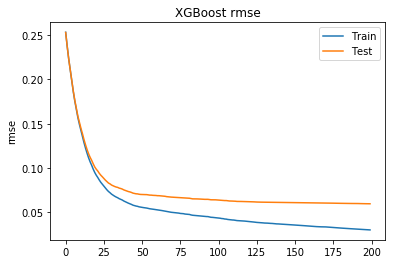

<Figure size 432x288 with 0 Axes>

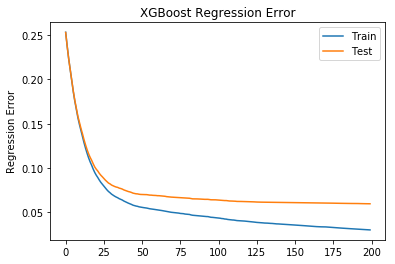

<Figure size 432x288 with 0 Axes>

In [173]:
#Ajustado o modelo para evitar overfitting
X_train, X_test, y_train, y_test = train_test_split(
        train_final_data, target_final_data_train_scaled, train_size=0.7 , random_state = 1)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
R2score = r2_score(y_test, predictions)
print("Score: %.2f%%" % (R2score))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('rmse')
pyplot.title('XGBoost rmse')
pyplot.show()
plt.savefig('XGBoost rmse x Validation .png', format='png', dpi=100)
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('Regression Error')
pyplot.title('XGBoost Regression Error')
pyplot.show()
plt.savefig('XGBoost Error x Validation .png', format='png', dpi=100)

[0]	validation_0-rmse:0.253129
Will train until validation_0-rmse hasn't improved in 3 rounds.
[1]	validation_0-rmse:0.237432
[2]	validation_0-rmse:0.22303
[3]	validation_0-rmse:0.210883
[4]	validation_0-rmse:0.198255
[5]	validation_0-rmse:0.186681
[6]	validation_0-rmse:0.17618
[7]	validation_0-rmse:0.167462
[8]	validation_0-rmse:0.158366
[9]	validation_0-rmse:0.151253
[10]	validation_0-rmse:0.144663
[11]	validation_0-rmse:0.138536
[12]	validation_0-rmse:0.131889
[13]	validation_0-rmse:0.126054
[14]	validation_0-rmse:0.120694
[15]	validation_0-rmse:0.115916
[16]	validation_0-rmse:0.111922
[17]	validation_0-rmse:0.108548
[18]	validation_0-rmse:0.10461
[19]	validation_0-rmse:0.101075
[20]	validation_0-rmse:0.098538
[21]	validation_0-rmse:0.096452
[22]	validation_0-rmse:0.093846
[23]	validation_0-rmse:0.091703
[24]	validation_0-rmse:0.08991
[25]	validation_0-rmse:0.087919
[26]	validation_0-rmse:0.086095
[27]	validation_0-rmse:0.084418
[28]	validation_0-rmse:0.082856
[29]	validation_0-rmse

KeyError: 'validation_1'

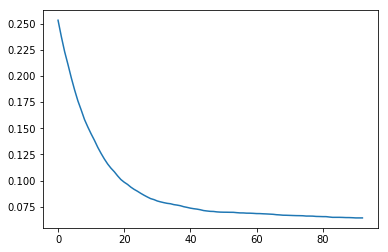

In [176]:
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=3, eval_metric="rmse", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
Score = r2_score(y_test, predictions)
print("Score: %.2f%%" % (Score))
# retrieve performance metrics
results2 = model.evals_result()
epochs2 = len(results2['validation_0']['rmse'])
x_axis2 = range(0, epochs2)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis2, results2['validation_0']['rmse'], label='Train')
ax.plot(x_axis2, results2['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('rmse')
pyplot.title('XGBoost rmse')
pyplot.show()
plt.savefig('XGBoost rmse x Validation2 .png', format='png', dpi=100)

In [99]:
target_final_data_train.max()

cycle_num    357
dtype: int64

In [155]:
# Params = (n_estimators = 200, 
#          learning_rate = 0.4,
#          colsample_bytree = 0.7,
#          max_depth = 5)
X_train, X_test, y_train, y_test = train_test_split(
        train_final_data, target_final_data_train_scaled, train_size=0.7 , random_state = 1)

from xgboost import XGBRegressor as xgb        

#n_estimators=200, learning_rate=0.07, gamma=0, subsample=0.8,colsample_bytree=0.7, max_depth=10
model = xgb(n_estimators=200, learning_rate=0.07, gamma=0, subsample=0.8,colsample_bytree=0.7, max_depth=10)
#early_stopping_rounds=10,eval_metric="rmse",  verbose=True
#model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

X_test_df = pd.DataFrame(X_test)
y_pred_final = pd.DataFrame(y_pred * 357 , columns = ['y_pred'], index = X_test_df.index)

#Saving the model
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [157]:
data_colunas = [y_pred_final,target_final_data_train,X_test_df]
# target_final_data_train

engine_train = pd.concat(data_colunas, axis = 1, ignore_index=False,verify_integrity=True)

engine_train = engine_train.dropna(axis = 0, how = 'any')

engine_train.tail()

,y_pred,cycle_num,unit,overall_setting,mean_setting1_and_setting2,sensor2,sensor3,sensor4,sensor7,sensor8,...,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor20,"sensor9,14_break",sensor2_break
45902,138.170364,118,218.0,1.0,21.42185,0.609907,0.653712,0.637759,0.546479,0.079365,...,0.660000,0.344444,0.068452,0.060274,0.791525,0.0,0.4,0.394737,1.0,1.0
45903,124.855682,119,218.0,3.0,5.12770,0.701220,0.662026,0.677512,0.179361,0.660714,...,0.611842,0.313043,0.620690,0.074997,0.780723,0.0,0.8,0.412371,1.0,1.0
45905,127.091087,121,218.0,3.0,5.12670,0.664634,0.521784,0.713110,0.280098,0.642857,...,0.776316,0.223188,0.775862,0.086759,0.693976,0.0,0.7,0.484536,1.0,1.0
45907,135.730957,123,218.0,1.0,21.42345,0.702786,0.797999,0.766746,0.281690,0.069841,...,0.693333,0.322222,0.077381,0.037352,0.648127,0.0,0.6,0.315789,1.0,1.0
45913,140.186539,129,218.0,1.0,21.42330,0.848297,0.688155,0.837719,0.343662,0.047619,...,0.773333,0.359259,0.056548,0.067462,0.799849,0.0,0.6,0.447368,1.0,1.0


In [178]:
d = []

for index, row in engine_train.iterrows():
     d.append(row.y_pred - row.cycle_num)
        
engine_train['d'] = d

In [179]:
def metrica(d):
    
    aux = 0
    for i in d:
        
        if (i < 0):
            aux = aux + (np.exp((-(i/13)))-1)           
        else:
            aux = aux + (np.exp(((i/10)))-1)
#         print aux
    return aux  

# Resultado Final

In [180]:
result = metrica(engine_train['d'])

print ('O resultado final para o set de treino foi de {:.2f} pontos.'.format(result))

O resultado final para o set de treino foi de 135297.47 pontos.


In [182]:
np.sum((engine_train['d'] < 0).values.ravel())

6804

In [184]:
np.sum((engine_train['d'] > 0).values.ravel())

6972

In [185]:
engine_train.describe()

,y_pred,cycle_num,unit,overall_setting,mean_setting1_and_setting2,sensor2,sensor3,sensor4,sensor7,sensor8,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor20,"sensor9,14_break",sensor2_break,d
count,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000,...,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000,13776.000000
mean,109.605385,109.808798,108.932709,2.353876,12.213666,0.450677,0.445488,0.433543,0.525002,0.265842,...,0.521449,0.277884,0.204316,0.448939,0.034190,0.462754,0.511124,0.592552,0.621661,-0.203202
std,62.845062,67.798217,63.116776,1.674878,7.547862,0.140627,0.137211,0.151179,0.144714,0.151291,...,0.145369,0.162879,0.094561,0.152711,0.181723,0.150000,0.146472,0.491377,0.484990,21.218853
min,11.456143,1.000000,1.000000,0.000000,0.000000,0.002857,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.004426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-108.779205
25%,45.376260,53.000000,53.000000,1.000000,5.127450,0.352941,0.350274,0.326543,0.429825,0.159091,...,0.426087,0.161585,0.149313,0.340003,0.000000,0.333333,0.411111,0.000000,0.000000,-15.013016
50%,115.659542,106.000000,108.000000,2.000000,12.810750,0.443730,0.438266,0.419030,0.526761,0.221498,...,0.524638,0.226190,0.187736,0.434355,0.000000,0.444444,0.513158,1.000000,1.000000,0.333698
75%,156.606747,159.000000,164.000000,4.000000,17.924363,0.540000,0.531757,0.527757,0.624402,0.339286,...,0.622318,0.362069,0.234057,0.546289,0.000000,0.555556,0.611111,1.000000,1.000000,14.803755
max,337.077698,352.000000,218.000000,5.000000,21.424950,1.000000,0.993966,1.000000,0.991197,1.000000,...,0.988406,1.000000,1.000000,1.000000,1.000000,1.000000,0.989691,1.000000,1.000000,68.380630


In [119]:
target_final_data_test.max()

cycle_num    357
dtype: int64

# Test Data

In [151]:
# load the model from disk

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(test_final_data, target_final_data_test_scaled)

y_pred = model.predict(test_final_data)

X_test_df = pd.DataFrame(test_final_data)
y_pred_final = pd.DataFrame(y_pred * 357 , columns = ['y_pred'], index = X_test_df.index)

#Saving the model
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [152]:
data_colunas = [y_pred_final,target_final_data_test,X_test_df]
# target_final_data_test

engine_test = pd.concat(data_colunas, axis = 1, ignore_index=False,verify_integrity=True)

engine_test = engine_test.dropna(axis = 0, how = 'any')

engine_test.head()

,y_pred,cycle_num,unit,overall_setting,mean_setting1_and_setting2,sensor2,sensor3,sensor4,sensor7,sensor8,...,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor20,"sensor9,14_break",sensor2_break
0,68.796028,1,1.0,3.0,0.00090,0.615894,0.419827,0.574623,0.516949,0.555556,...,0.537313,0.505263,0.512821,0.104694,0.436355,0.0,0.500,0.643564,0,1
1,69.692291,2,1.0,2.0,12.81040,0.328829,0.550015,0.660580,0.302326,0.066667,...,0.482456,0.367257,0.047619,0.122325,0.441482,0.0,0.500,0.536232,0,0
2,71.590057,3,1.0,3.0,0.00020,0.539735,0.495670,0.508444,0.724576,0.722222,...,0.477612,0.428947,0.743590,0.079218,0.557069,0.0,0.500,0.584158,0,1
3,62.369377,4,1.0,1.0,5.12670,0.386986,0.440057,0.587241,0.387013,0.460000,...,0.428571,0.466443,0.612245,0.166244,0.624539,0.0,0.375,0.540230,0,0
4,76.029678,5,1.0,3.0,0.00175,0.569536,0.367871,0.476038,0.559322,0.583333,...,0.604478,0.352632,0.589744,0.054615,0.555660,0.0,0.375,0.495050,0,1


In [153]:
d = []

for index, row in engine_test.iterrows():
     d.append(row.y_pred - row.cycle_num)
        
engine_test['d'] = d

engine_test['d'].head()

0    67.796028
1    67.692291
2    68.590057
3    58.369377
4    71.029678
Name: d, dtype: float64

In [154]:
result = metrica(engine_test['d'])

print ('O resultado final para o set de treino foi de {:.2f} pontos.'.format(result))

O resultado final para o set de treino foi de 598144934.58 pontos.


# Análise final com o dataset 'final_test'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(finaltest_final_data, target_final_data_finaltest_scaled, 
                                                    train_size=0 , random_state = 1)

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)

y_pred = loaded_model.predict(X_test)

X_test_df = pd.DataFrame(X_test)
y_pred_final = pd.DataFrame(y_pred * target_final_data_finaltest.max(), columns = ['y_pred'], index = X_test.index)

print(result)

In [ ]:
data_colunas = [y_pred_final,X_test_df]
# target_final_data_test

engine_finaltest = pd.concat(data_colunas, axis = 1, ignore_index=False,verify_integrity=True)

engine_finaltest = engine_finaltest.dropna(axis = 0, how = 'any')

engine_finaltest.head()

In [ ]:
d = []

for index, row in engine_finaltest.iterrows():
     d.append(row.y_pred - row.cycle_num)
        
engine_finaltest['d'] = d

engine_finaltest['d'].head()

In [ ]:
result = metrica(engine_finaltest['d'])

print ('O resultado final para o set de treino foi de {} pontos.'.format(result))

In [ ]:
X_test_df = pd.DataFrame(X_test)
y_pred_final = pd.DataFrame(y_pred * target_final_data_finaltest.max(), columns = ['y_pred'], index = X_test.index)
d = []

data_colunas = [y_pred_final,X_test_df]
# target_final_data_test

engine_finaltest = pd.concat(data_colunas, axis = 1, ignore_index=False,verify_integrity=True)

engine_finaltest = engine_finaltest.dropna(axis = 0, how = 'any')

for index, row in engine_finaltest.iterrows():
     d.append(row.y_pred - row.cycle_num)
        
engine_finaltest['d'] = d

engine_finaltest['d'].head()